<a href="https://colab.research.google.com/github/yassminyasser491-cyber/Teeth-Classification/blob/main/Task_4_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import zipfile

# This line triggers the file picker UI in Colab
uploaded = files.upload()

# Extract the name of the uploaded zip file
zip_filename = next(iter(uploaded.keys()))

# Extract the uploaded zip into a folder named 'dataset'
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('dataset')

print(f"Uploaded and extracted: {zip_filename}")


Saving data-20250926T213051Z-1-001.zip to data-20250926T213051Z-1-001.zip
Uploaded and extracted: data-20250926T213051Z-1-001.zip


In [2]:
!pip install segmentation-models --quiet
!pip install tifffile --quiet
!pip install scikit-learn --quiet
!pip install pillow --quiet
!pip install tensorflow tensorflow_hub --quiet
!pip install tifffile pillow scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import os
import tifffile as tiff
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
import tensorflow as tf


In [4]:
image_dir = 'dataset/data/images'
mask_dir = 'dataset/data/labels'

def extract_id(filename):
    return filename.split('.')[0]

image_ids = {extract_id(f) for f in os.listdir(image_dir)}
mask_ids = {extract_id(f) for f in os.listdir(mask_dir)}
common_ids = sorted(list(image_ids & mask_ids))

X_list, Y_list = [], []
for img_id in common_ids:
    img_path = os.path.join(image_dir, img_id + '.tif')
    mask_path = None
    if os.path.exists(os.path.join(mask_dir, img_id + '.png')):
        mask_path = os.path.join(mask_dir, img_id + '.png')
    elif os.path.exists(os.path.join(mask_dir, img_id + '.tif')):
        mask_path = os.path.join(mask_dir, img_id + '.tif')
    else:
        continue
    img = tiff.imread(img_path).astype(np.float32)
    mask = np.array(Image.open(mask_path))
    mask = (mask > 0).astype(np.uint8)
    X_list.append(img)
    Y_list.append(mask)

X = np.stack(X_list)  # (N,128,128,12)
Y = np.stack(Y_list)  # (N,128,128)


In [5]:
X_norm = np.zeros_like(X, dtype=np.float32)
for img_idx in range(X.shape[0]):           # Loop over all images
    for band_idx in range(X.shape[-1]):     # Loop over all bands
        band = X[img_idx, ..., band_idx]
        band_min = band.min()
        band_max = band.max()
        X_norm[img_idx, ..., band_idx] = (band - band_min) / (band_max - band_min + 1e-8)


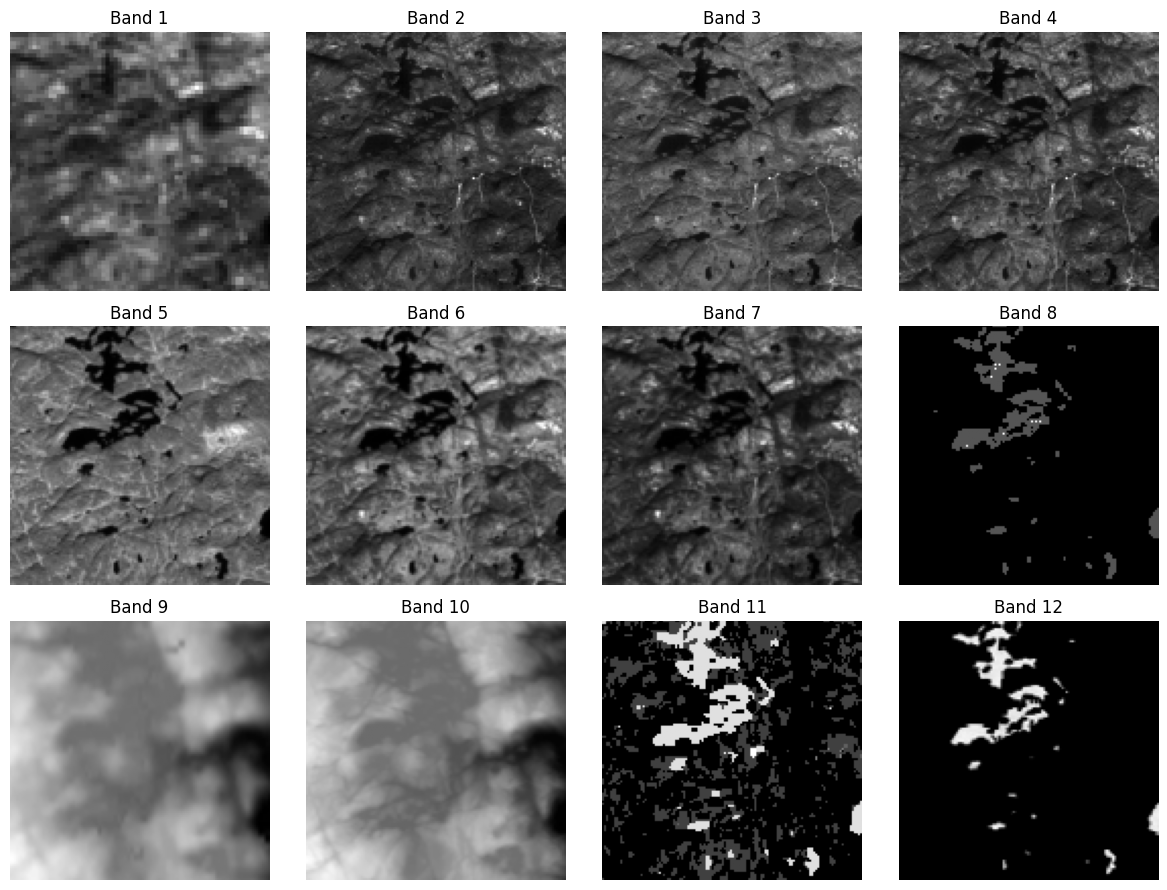

In [6]:
fig, axs = plt.subplots(3,4, figsize=(12,9))
for i in range(12):
    ax = axs[i//4, i%4]
    ax.imshow(X_norm[0,...,i], cmap='gray')
    ax.set_title(f'Band {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()


In [12]:
X3 = X_norm[..., [2, 3, 5]]  # Correct: bands 4, 6, 7

X_train, X_test, Y_train, Y_test = train_test_split(X3, Y, test_size=0.2, random_state=42)


In [13]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False, weights='imagenet')
layer_names = [
    'block_1_expand_relu',  # 64x64
    'block_3_expand_relu',  # 32x32
    'block_6_expand_relu',  # 16x16
    'block_13_expand_relu', # 8x8
    'block_16_project',     # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False  # Freeze encoder weights

def upsample(filters, size):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU()
    ])

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

inputs = tf.keras.layers.Input(shape=[128, 128, 3])
x = inputs
skips = down_stack(x)
x = skips[-1]
skips = reversed(skips[:-1])
for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])
x = tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x)
outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_6        │ [(None, 64, 64,   │  1,841,984 │ input_layer_7[0]… │
│ (Functional)        │ 96), (None, 32,   │            │                   │
│                     │ 32, 144), (None,  │            │                   │
│                     │ 16, 16, 192),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 576), (None, 4,   │            │                   │
│                     │ 4, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  1,477,120 │ functional_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 8, 8,      │          0 │ sequential_4[0][… │
│ (Concatenate)       │ 1088)             │            │ functional_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 16, 16,    │  2,508,032 │ concatenate_4[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 16, 16,    │          0 │ sequential_5[0][… │
│ (Concatenate)       │ 448)              │            │ functional_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 32, 32,    │    516,736 │ concatenate_5[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 32, 32,    │          0 │ sequential_6[0][… │
│ (Concatenate)       │ 272)              │            │ functional_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 64, 64,    │    156,992 │ concatenate_6[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 64, 64,    │          0 │ sequential_7[0][… │
│ (Concatenate)       │ 160)              │            │ functional_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_9  │ (None, 128, 128,  │     46,112 │ concatenate_7[0]… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │         33 │ conv2d_transpose… │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,547,009 (24.97 MB)

 Trainable params: 4,703,105 (17.94 MB)

 Non-trainable params: 1,843,904 (7.03 MB)

In [19]:
history = model.fit(
    X_train, Y_train[..., np.newaxis],
    validation_split=0.1,
    epochs=80,
    batch_size=8
)


Epoch 1/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9795 - loss: 0.0519 - val_accuracy: 0.9529 - val_loss: 0.1928
Epoch 2/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9782 - loss: 0.0568 - val_accuracy: 0.9458 - val_loss: 0.1818
Epoch 3/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9759 - loss: 0.0611 - val_accuracy: 0.9470 - val_loss: 0.2489
Epoch 4/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9808 - loss: 0.0475 - val_accuracy: 0.9525 - val_loss: 0.1981
Epoch 5/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9813 - loss: 0.0469 - val_accuracy: 0.9487 - val_loss: 0.1848
Epoch 6/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9848 - loss: 0.0383 - val_accuracy: 0.9498 - val_loss: 0.1767
Epoch 7/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9858 - loss: 0.0361 - val_accuracy: 0.9527 - val_loss: 0.1946
Epoch 8/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9860 - loss: 0.0353 - val_accuracy: 0.9510 - v

In [20]:
Y_pred = model.predict(X_test)
Y_pred_bin = (Y_pred[...,0] > 0.3).astype(np.uint8)

flat_true = Y_test.flatten()
flat_pred = Y_pred_bin.flatten()

iou = jaccard_score(flat_true, flat_pred)
precision = precision_score(flat_true, flat_pred)
recall = recall_score(flat_true, flat_pred)
f1 = f1_score(flat_true, flat_pred)

print(f"IoU: {iou:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
IoU: 0.748
Precision: 0.871
Recall: 0.841
F1 Score: 0.856


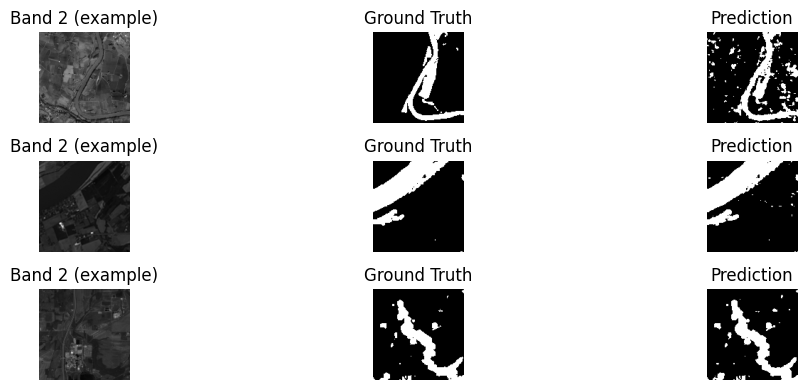

In [23]:
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(3,3,3*i + 1)
    plt.imshow(X_test[i][...,0], cmap='gray')
    plt.title('Band 2 (example)')
    plt.axis('off')
    plt.subplot(3,3,3*i + 2)
    plt.imshow(Y_test[i], cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(3,3,3*i + 3)
    plt.imshow(Y_pred_bin[i], cmap='gray')
    plt.title('Prediction')
    plt.axis('off')
plt.tight_layout()
plt.show()
